In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import numpy as np
import glob
from PIL import Image
import pandas as pd

In [ ]:
#Read rgb infor for each label
df = pd.read_csv('class_dict.csv',index_col=0)
colors = {cl:list(df.loc[cl, :]) for cl in df.index}

idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(colors.items())}

In [ ]:
#Function to create a semantic map to feed as label to UNET
def create_mask(mask):
    semantic_map = []
    #mask = mask.T
    for colour in list(colors.values()):
        equality = mask == colour# 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x3 True only at the found color, and all False otherwise.

    return np.float32(semantic_map)# convert True/False to numbers

def map_to_rgb(p):
    return idx2rgb[p[0]]

In [ ]:
#Read all image and label filenames
all_images=[]
all_gts=[]


root_dir="TrainingData"
for filename in glob.iglob(root_dir + '**/*.png', recursive=True):
    all_images.append(filename)

for filename in glob.iglob(root_dir + '**/*.npy', recursive=True):
    all_gts.append(filename)

In [ ]:
#Get all npy files as images
all_gts_imgs={}
for gt in all_gts:
    a=np.load(gt)
    #a = Image.fromarray(a)
    #if a.mode != 'RGB':
        #a = a.convert('RGB')
    all_gts_imgs[gt]=a

In [ ]:
#Function to normalize the image to have values between 0 and 1
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [ ]:
all_input_images={}
all_input_masks={}


In [ ]:
for i in range(len(all_images)):
    image_path_png = all_images[i]
    img = tf.io.read_file(image_path_png)
    img = tf.image.decode_png(img)
    input_image = tf.image.resize(img, (256, 256))
    input_image, input_mask = normalize(input_image, all_gts_imgs[all_gts[i]])
    all_input_images[all_images[i]]=input_image
    all_input_masks[all_gts[i]]=input_mask

In [ ]:
#Lists to hold all images and masks
check_imgs=list(all_input_images.values()) #256x256x3 list of all images
check_masks=list(all_input_masks.values())#256x256 list of all labels

In [ ]:
def color_labels(output):
    label_to_color = {
    0: [136, 8, 8],
    1: [0,0,255],
    2: [ 0, 255, 255],
}

    img_classes = Image.fromarray(output)

    img_classes_p = img_classes.convert('P')
    img_classes_p.putpalette(
        [rgb for pixel in label_to_color.values() for rgb in pixel])

    img_rgb = img_classes_p.convert('RGB')
    return img_rgb
    """
    plt.figure(figsize=(24, 8))
    plt.subplot(1, 3, 1), plt.imshow(img_classes)
    plt.subplot(1, 3, 2), plt.imshow(img_classes_p)
    plt.subplot(1, 3, 3), plt.imshow(img_rgb)
    plt.tight_layout(), plt.show()
    """

In [ ]:
#Creating all semantic maps from the masks list
semantic_maps=[]
for mask in check_masks:
    current_img=color_labels(mask)
    s_map=create_mask(np.array(current_img))
    semantic_maps.append(s_map)

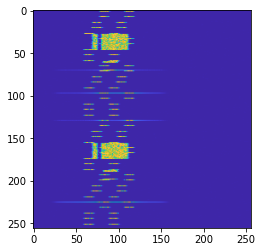

In [ ]:
plt.imshow(tf.keras.utils.array_to_img(check_imgs[-1]))


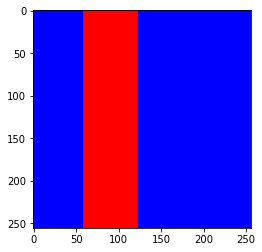

In [ ]:
plt.imshow(semantic_maps[-1])

In [ ]:
# Split the training dataset for testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(check_imgs,semantic_maps, test_size=0.3, random_state=4)

#To create Datasets
train_images=tf.data.Dataset.from_tensors(tuple(zip(tuple(x_train),tuple(y_train))))
test_images=tf.data.Dataset.from_tensors(tuple(zip(tuple(x_test),tuple(y_test))))

In [ ]:
x_train, x_test, y_train, y_test=np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [ ]:
batch_sz = 4
epochs = 1

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [ ]:
#Implementation of UNET
def UNET(input_size = (256,256,3), n_class = 3,pretrained ='unet_weigths.hdf5'):
  input = Input(input_size)
  # down_ssampling layer (encoder par)
  down_s_11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  down_s_12 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down_s_11)
  pool1 = MaxPooling2D(pool_size=(2, 2))(down_s_12)

  down_s_21 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  down_s_22 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down_s_21)
  pool2 = MaxPooling2D(pool_size=(2, 2))(down_s_22)

  down_s_31 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  down_s_32 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down_s_31)
  pool3 = MaxPooling2D(pool_size=(2, 2))(down_s_32)

  down_s_41 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  down_s_42 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down_s_41)
  drop4 = Dropout(0.5)(down_s_42)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  down_s_51 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  down_s_52 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down_s_51)
  drop5 = Dropout(0.5)(down_s_52)

  # decoder part of Unet architecture
  up_s_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge = concatenate([drop4,up_s_1], axis = 3)
  conv_11 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
  conv_12 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_11)

  up_s_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_12))
  merge = concatenate([down_s_32,up_s_2], axis = 3)
  conv_21 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
  conv_22 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_21)

  up_s_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_22))
  merge = concatenate([down_s_22,up_s_3], axis = 3)
  conv_31 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
  conv_32 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_31)

  up_s_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_32))
  merge = concatenate([down_s_12,up_s_4], axis = 3)
  conv_41 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
  conv_42 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_41)



  out = Conv2D(n_class, (1,1), padding='same')(conv_42)
  print(out.shape)
  output_layer = Activation('softmax')(out)
  model = Model(input,output_layer)

  if pretrained:
    model.load_weights(pretrained)

  return model


In [ ]:
model = UNET(n_class= 3)
model.summary()

(None, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_46 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_45[0][0]']              
                                )                                       

                                                                                                  
 conv2d_63 (Conv2D)             (None, 128, 128, 12  147584      ['conv2d_62[0][0]']              
                                8)                                                                
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 256, 256, 12  0          ['conv2d_63[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_64 (Conv2D)             (None, 256, 256, 64  32832       ['up_sampling2d_7[0][0]']        
                                )                                                                 
                                                                                                  
 concatena

In [ ]:
model_checkpoint = ModelCheckpoint('unet_weigths.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(x=x_train, y=y_train,validation_split=0.2,batch_size=batch_sz,epochs=epochs, callbacks=[model_checkpoint])

In [ ]:
# Load the model incase training was done before
model=load_model('unet_weigths.hdf5')

In [ ]:
# testing on test images from test set
img = x_test[25]
g_label = y_test[25]
g_label = np.apply_along_axis(map_to_rgb, -1, np.expand_dims(np.argmax(g_label, axis=-1), -1))
output = model.predict(np.expand_dims(img, 0))
predict_mask = np.argmax(output, axis=-1)
predict_mask = np.apply_along_axis(map_to_rgb, -1, np.expand_dims(predict_mask, -1))

1/1 [==============================] - 0s 209ms/step


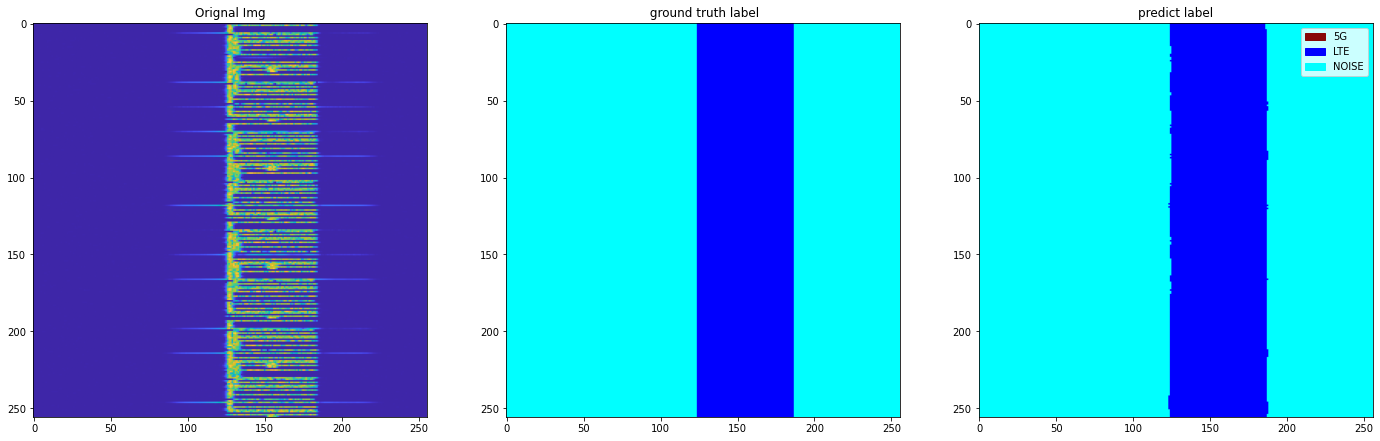

In [ ]:
import matplotlib.patches as mpatches
plt.figure(figsize=(24, 8))
plt.subplot(1,3,1)
plt.title('Orignal Img')
plt.imshow(img)
plt.subplot(1,3,2)
plt.title(' ground truth label')
plt.imshow(g_label)
plt.subplot(1,3,3)
plt.title('predict label')
plt.imshow(predict_mask[0])
NR = mpatches.Patch(color='#880808', label='5G')
LTE = mpatches.Patch(color='#0000ff', label='LTE')
Noise = mpatches.Patch(color='#00ffff', label='NOISE')
plt.legend(handles=[NR,LTE,Noise])

In [ ]:
#Testing on images with both 5G and LTE signals
image_path_png = root_dir+"/LTE_NR/LTE_NR_frame_55.png"
img = tf.io.read_file(image_path_png)
img = tf.image.decode_png(img)
input_image = tf.image.resize(img, (256, 256))
#input_mask = tf.image.resize(all_gts_imgs[all_gts[i]], (256, 256))
input_image = tf.cast(input_image, tf.float32) / 255.0

In [ ]:
img = input_image
#g_label = y_test[0]
#g_label = np.apply_along_axis(map_to_rgb, -1, np.expand_dims(np.argmax(g_label, axis=-1), -1))
output = model.predict(np.expand_dims(img, 0))
predict_mask = np.argmax(output, axis=-1)
predict_mask = np.apply_along_axis(map_to_rgb, -1, np.expand_dims(predict_mask, -1))

1/1 [==============================] - 0s 217ms/step


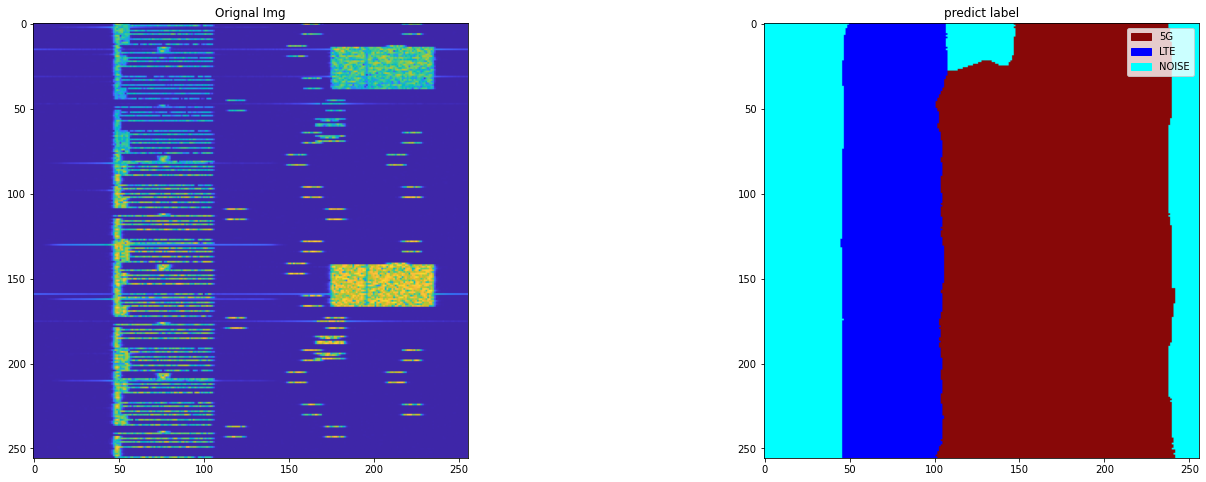

In [ ]:
import matplotlib.patches as mpatches
plt.figure(figsize=(24, 8))
plt.subplot(1,2,1)
plt.title('Orignal Img')
plt.imshow(img)
#plt.subplot(1,2,2)
#plt.title(' ground truth label')
#plt.imshow(g_label)
plt.subplot(1,2,2)
plt.title('predict label')
plt.imshow(predict_mask[0])
NR = mpatches.Patch(color='#880808', label='5G')
LTE = mpatches.Patch(color='#0000ff', label='LTE')
Noise = mpatches.Patch(color='#00ffff', label='NOISE')
plt.legend(handles=[NR,LTE,Noise])
